## 来源《高级人工智能课程》作业

In [1]:
!wget --no-check-certificate https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz


--2022-04-23 21:21:27--  https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: ‘cifar-10-binary.tar.gz’

cifar-10-binary.tar 100%[===================>] 162.17M  6.48MB/s    in 27s     

2022-04-23 21:21:55 (6.07 MB/s) - ‘cifar-10-binary.tar.gz’ saved [170052171/170052171]



In [2]:
!tar -zvxf cifar-10-binary.tar.gz


cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin
cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin
cifar-10-batches-bin/data_batch_4.bin
cifar-10-batches-bin/test_batch.bin
cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin
cifar-10-batches-bin/data_batch_2.bin


In [3]:
import os
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits
from mindspore.communication.management import init
from mindspore.nn.optim.momentum import Momentum
from mindspore import Model, context
from mindspore.context import ParallelMode
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import load_checkpoint, load_param_into_net
from mindspore.parallel._auto_parallel_context import auto_parallel_context

In [4]:
cifar_ds = ds.Cifar10Dataset('./cifar-10-batches-bin')


The type of mnist_ds: <class 'mindspore.dataset.engine.datasets.Cifar10Dataset'>
Number of pictures contained in the cifar_ds： 60000
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (32, 32, 3)
The label of item: 0


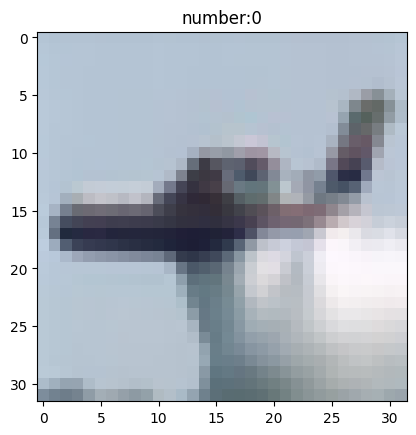

In [5]:
print('The type of mnist_ds:', type(cifar_ds))
print("Number of pictures contained in the cifar_ds：",
      cifar_ds.get_dataset_size())
#迭代器读取数据
dic_ds = cifar_ds.create_dict_iterator()
item = next(dic_ds)
img = item["image"].asnumpy()
label = item["label"].asnumpy()
#打印数据集信息 并可视化
print("The item of mnist_ds:", item.keys())
print("Tensor of image in item:", img.shape)
print("The label of item:", label)
plt.imshow(np.squeeze(img))
plt.title("number:%s"% item["label"].asnumpy())
plt.show()

In [6]:
"""
-------定义dataset（dataloader）-----
"""
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype

def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    #调用API读取MNIST数据集合
    cifar_ds = ds.Cifar10Dataset('./cifar-10-batches-bin')
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081
    #根据上面设置的参数阐释增强数据过程
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)
    #使用map函数对数据集进行操作
    cifar_ds = cifar_ds.map(operations=type_cast_op, input_columns="label",
                            num_parallel_workers=num_parallel_workers)
    cifar_ds = cifar_ds.map(operations=resize_op, input_columns="image",
                            num_parallel_workers=num_parallel_workers)
    cifar_ds = cifar_ds.map(operations=rescale_op, input_columns="image",
                            num_parallel_workers=num_parallel_workers)
    cifar_ds = cifar_ds.map(operations=rescale_nml_op, input_columns="image",
                            num_parallel_workers=num_parallel_workers)
    cifar_ds = cifar_ds.map(operations=hwc2chw_op, input_columns="image",
                            num_parallel_workers=num_parallel_workers)
    # 设置数据读取，比如是否随机，批次量多少，数据量加倍
    buffer_size = 10000
    cifar_ds = cifar_ds.shuffle(buffer_size=buffer_size)
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    cifar_ds = cifar_ds.repeat(repeat_size)
    return cifar_ds


In [ ]:
# https://bbs.huaweicloud.com/forum/thread-179977-1-1.html

In [7]:
#初始化dataset并查看内容
ms_dataset = create_dataset('./cifar-10-batches-bin')
print('Number of groups in the dataset:', ms_dataset.get_dataset_size())

"""
-------利用next获取样本并查看单个样本格式------
"""
data =next(ms_dataset.create_dict_iterator(output_numpy=True))#填写
images = data['image']#填写
labels =data['label']#填写
print('Tensor of image:', images.shape)
print('Labels:', labels)

Number of groups in the dataset: 1875
Tensor of image: (32, 3, 32, 32)
Labels: [2 7 0 9 1 6 6 3 3 3 3 5 0 9 0 0 1 1 5 2 0 7 9 7 2 2 3 6 0 2 3 1]


In [17]:
import mindspore.nn as nn
from mindspore.common.initializer import Normal
class AnnNet(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self, num_class=10, num_channel=1):
        super(AnnNet, self).__init__()
        self.fc1=nn.Dense(32*32*3,100,weight_init=Normal(0.02))
        self.fc2=nn.Dense(100,50,weight_init=Normal(0.02))
        self.fc3=nn.Dense(50,20,weight_init=Normal(0.02))
        self.relu=nn.ReLU()
        self.tanh=nn.Tanh()
        self.flatten=nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x=self.flatten(x)
        x=self.relu(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x=self.tanh(self.fc3(x))
        return x


In [18]:
network = AnnNet()

In [19]:
from mindspore.train.callback import Callback
#自定义CallBlack函数
# 记录损失和精度
class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps_loss = steps_loss
        self.steps_eval = steps_eval
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        cur_step = (cur_epoch-1)*1875 + cb_params.cur_step_num
        self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
        self.steps_loss["step"].append(str(cur_step))
        if cur_step % 125 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])

In [20]:
import os
from mindspore import Tensor, Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.nn import Accuracy
network = AnnNet()
epoch_size = 30
momentum=0.9
lr=0.01
mnist_path =r"\datasets\MNIST_Data" #这里填写你的数据集路径
model_path =r"./"#模型保存路径
train_data_path = r"'./cifar-10-batches-bin'"
test_data_path = r"'./cifar-10-batches-bin'"
net_loss=SoftmaxCrossEntropyWithLogits(sparse=True,reduction='mean')
net_opt=nn.Momentum(network.trainable_params(),lr,momentum)

repeat_size = 1
ds_train = create_dataset(os.path.join(mnist_path, "train"), 256, repeat_size) # V100直接上512
eval_dataset = create_dataset(os.path.join(mnist_path, "test"), 256)

In [21]:
# 使用Model定义模型，这个模型包括损失函数，优化器，网络结构，
model =Model(network,net_loss,net_opt,metrics={'Accuracy':Accuracy()})#填写
# 保存模型和参数
config_ck =CheckpointConfig(save_checkpoint_steps=375,keep_checkpoint_max=16)#使用Checkpoint设置保存模型
ckpoint_cb =ModelCheckpoint(prefix="checkpoint_lenet",directory=model_path,config=config_ck)#使用ModelCheckpoint设置保存模型的名称地址等信息
steps_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}
# 保存每一步step,以及对应的损失和准确率信息

epoch: 1 step: 125, loss is 2.4356012
epoch: 2 step: 16, loss is 2.432759
epoch: 2 step: 141, loss is 2.4318266
epoch: 3 step: 32, loss is 2.431239
epoch: 3 step: 157, loss is 2.431046
epoch: 4 step: 48, loss is 2.4306462
epoch: 4 step: 173, loss is 2.4308598
epoch: 5 step: 64, loss is 2.4303794
epoch: 5 step: 189, loss is 2.4302945
epoch: 6 step: 80, loss is 2.4301572
epoch: 6 step: 205, loss is 2.4302328
epoch: 7 step: 96, loss is 2.4302428
epoch: 7 step: 221, loss is 2.430061
epoch: 8 step: 112, loss is 2.4300303
epoch: 9 step: 3, loss is 2.4299219
epoch: 9 step: 128, loss is 2.429949
epoch: 10 step: 19, loss is 2.4299235
epoch: 10 step: 144, loss is 2.4297874
epoch: 11 step: 35, loss is 2.4299452
epoch: 11 step: 160, loss is 2.4298472
epoch: 12 step: 51, loss is 2.4301097
epoch: 12 step: 176, loss is 2.429666
epoch: 13 step: 67, loss is 2.4298244
epoch: 13 step: 192, loss is 2.4298034
epoch: 14 step: 83, loss is 2.4297917
epoch: 14 step: 208, loss is 2.4298859
epoch: 15 step: 99, l

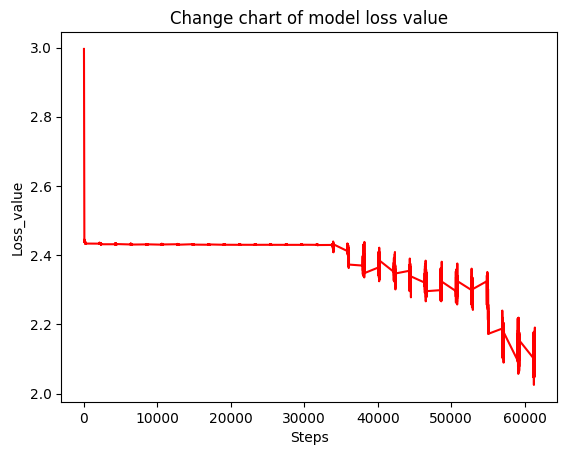

In [22]:
step_loss_acc_info = StepLossAccInfo(model,eval_dataset,steps_loss,steps_eval)#使用StepLossAccInfo类
#填写训练模型
model.train(epoch_size,ds_train,callbacks=[ckpoint_cb,LossMonitor(125),step_loss_acc_info],dataset_sink_mode=False)
"""
-------打印想训练过程-----
"""

steps = steps_loss["step"]
loss_value = steps_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Change chart of model loss value")
plt.show()

In [30]:
"""
------在测试集上验证模型-----
"""
from mindspore import load_checkpoint, load_param_into_net
#定义验证函数
def test_net(network, model, mnist_path):
    print("============== Starting Testing ==============")
    #填写  加载保存的模型
param_dict = load_checkpoint('./checkpoint_lenet-30_234.ckpt')#填写
load_param_into_net(network,param_dict)
ds_eval = create_dataset(mnist_path) #填写  创建测试集dataloader
acc =model.eval(ds_eval,dataset_sink_mode=False)#填写  输入模型获取精度
print("============== Accuracy:{} ==============".format(acc))
test_net(network, model, mnist_path)

============== Accuracy:{'Accuracy': 0.43} ==============
============== Starting Testing ==============
